In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
import os 

In [5]:
batch_size = 64

data_dir = os.path.join('/mnt', 'disks', 'disk-1', 'data')
csv_dir = os.path.join('data', 'CSVs')
models_dir = os.path.join(data_dir, 'models')
csv_path = {
    'train': os.path.join(csv_dir, 'tiles_train.csv'),
    'validation': os.path.join(csv_dir, 'tiles_validation.csv'),
    'test': os.path.join(csv_dir, 'tiles_test.csv'),
}

img_path = os.path.join(data_dir,
                        'tiles')

img_path_test = os.path.join(data_dir,
                        'tiles', 'tiles')
image_classes = ['cored', 'diffuse', 'CAA']

In [6]:
test = pd.read_csv(os.path.join(csv_dir, 'test_multilabel.csv'))

In [7]:
np.random.seed(42)
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
src_test = (ImageList.from_df(path=img_path_test, df=test, folder='hold-out')
       .split_none()
       .label_from_df(label_delim=' '))

In [18]:
data_test = (src_test.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
resnet = models.resnet50
acc_05 = partial(accuracy_thresh, thresh=0.5)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data_test, resnet, metrics=[acc_05, f_score])

In [19]:
model_name = 'stage-6-256-rn50'

In [20]:
learn = learn.load(os.path.join(models_dir, model_name))

In [21]:
learn.data.valid_dl = data_test.train_dl
learn.validate(metrics=[acc_05, f_score])

[0.05605167, tensor(0.9819), tensor(0.9726)]

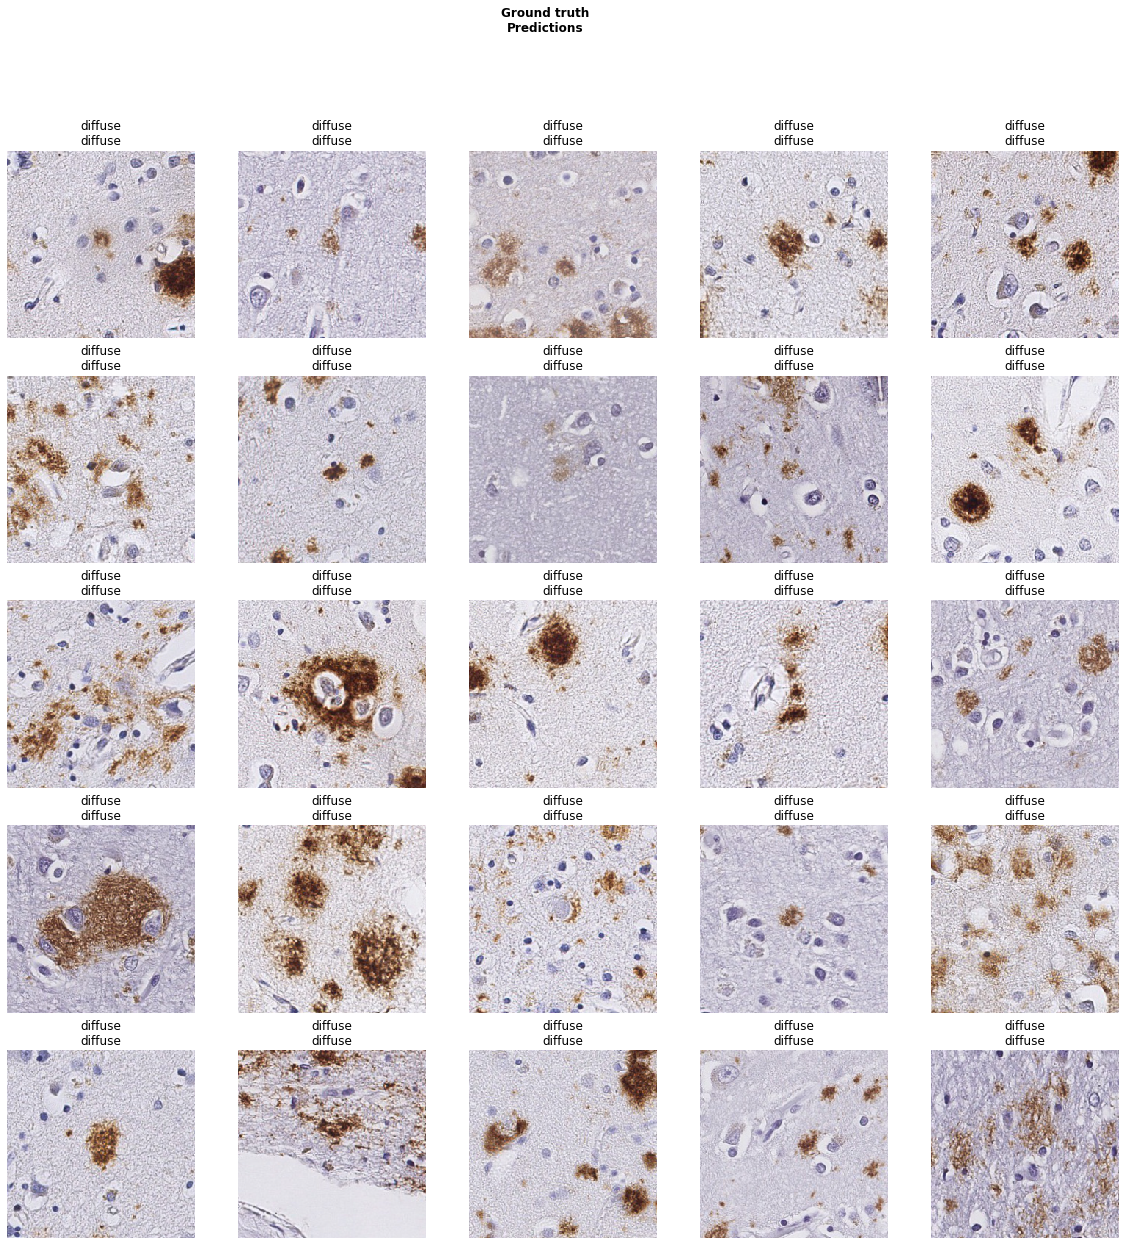

In [22]:
learn.show_results()

In [23]:
preds, y, losses = learn.get_preds(with_loss=True)

In [24]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    fig = plt.figure(figsize=(1.2*size, size))
    ax = plt.axes()
    for i in range(preds.shape[1]):
        fpr, tpr, _ = roc_curve(label[:,i].ravel(), preds[:,i].ravel())
        lw = 0.2*size
        # Plot all ROC curves
        ax.plot([0, 1], [0, 1], 'k--', lw=lw, label='random')
        ax.plot(fpr, tpr,
                 label='ROC-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(fpr, tpr)),
                  color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)
       
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=1.8*size)
    ax.set_ylabel('True Positive Rate', fontsize=1.8*size)
    ax.set_title('Receiver operating characteristic Curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc=0, fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

    
def plot_prc(preds, label, image_classes, size=20, path=None):
    colors = ['pink','c','deeppink', 'b', 'g', 'm', 'y', 'r', 'k']
    
    fig = plt.figure(figsize=(1.2*size,size))
    ax = plt.axes()
    
    for i in range(preds.shape[1]):
        rp = (label[:,i]>0).sum()/len(label)
        precision, recall, _ = precision_recall_curve(label[:,i].ravel(), preds[:,i].ravel())
        
        lw=0.2*size
    
        ax.plot(recall, precision,
                 label='PR-curve of {}'.format(image_classes[i])+ '( area = {0:0.3f})'
                ''.format(auc(recall, precision)),
                 color=colors[(i+preds.shape[1])%len(colors)], linewidth=lw)

        ax.plot([0, 1], [rp, rp], 'k--', color=colors[(i+preds.shape[1])%len(colors)], lw=lw, label='random')
   
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=1.8*size)
    ax.set_ylabel('Precision', fontsize=1.8*size)
    ax.set_title('Precision-Recall curve', fontsize=1.8*size, y=1.01)
    ax.legend(loc="lower left", bbox_to_anchor=(0.01, 0.1), fontsize=1.5*size)
    ax.xaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    ax.yaxis.set_tick_params(labelsize=1.6*size, size=size/2, width=0.2*size)
    
    if path != None:
        fig.savefig(path)
#         plt.close(fig)
        print('saved')

saved
saved


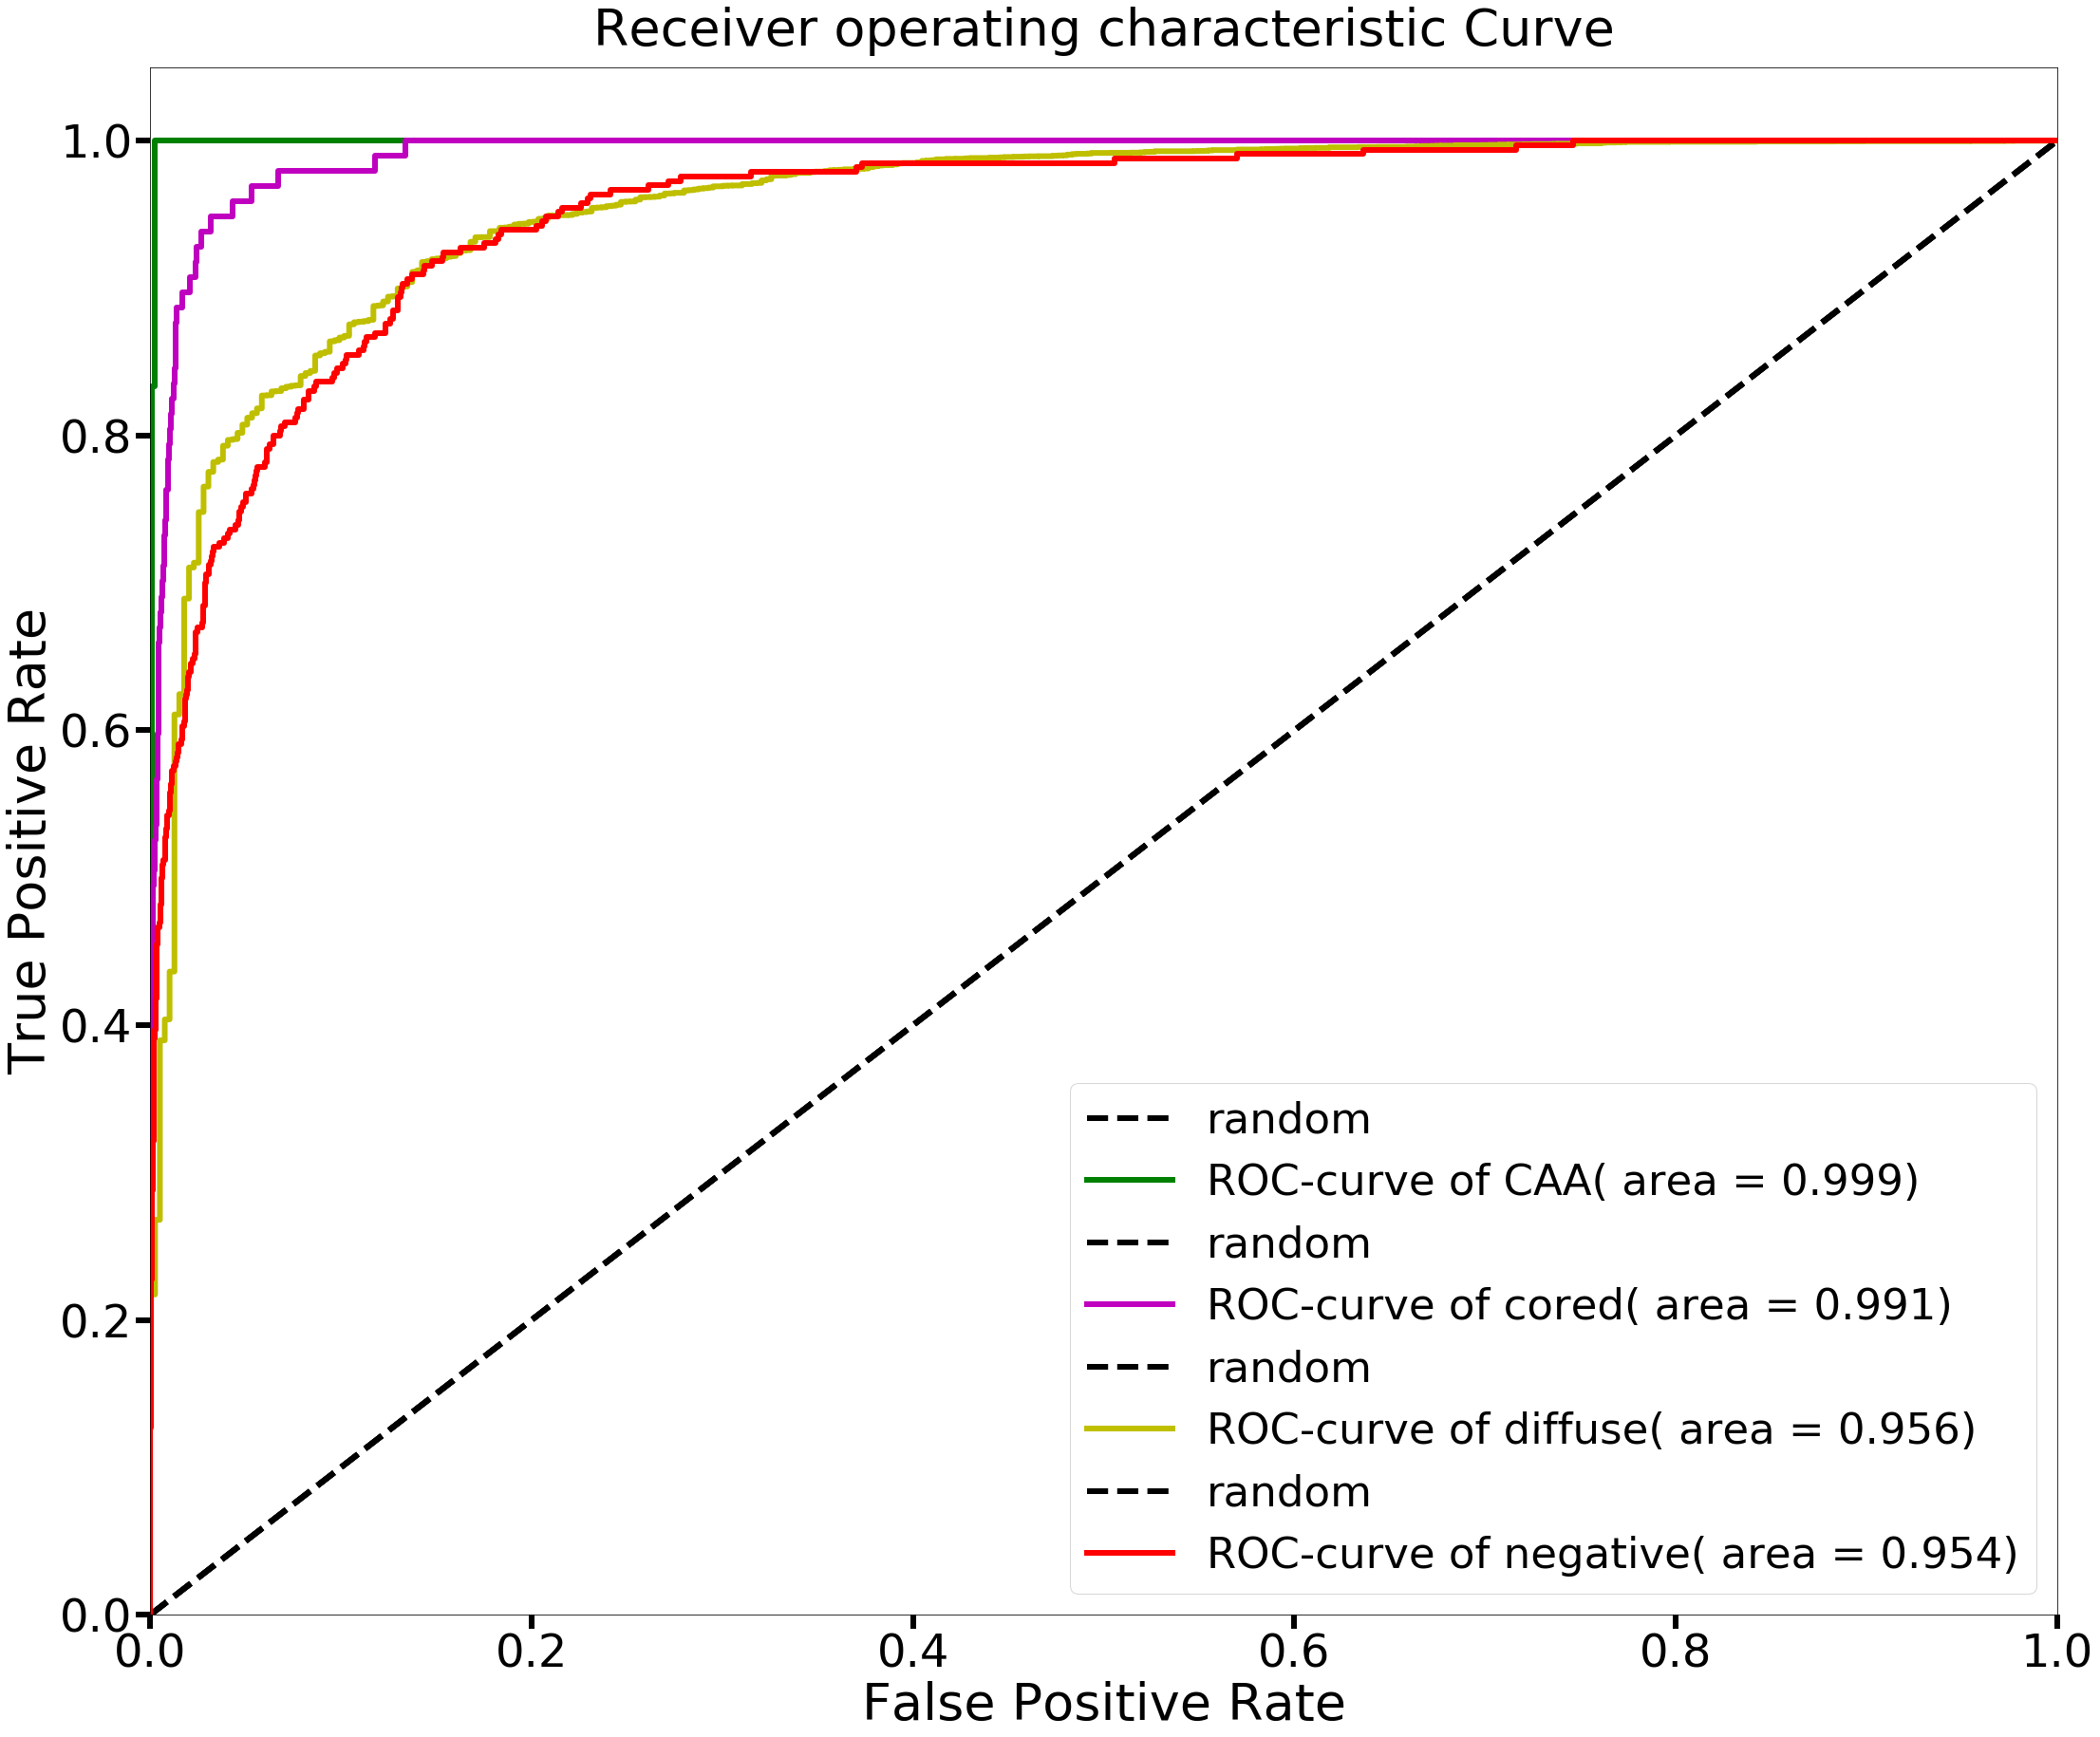

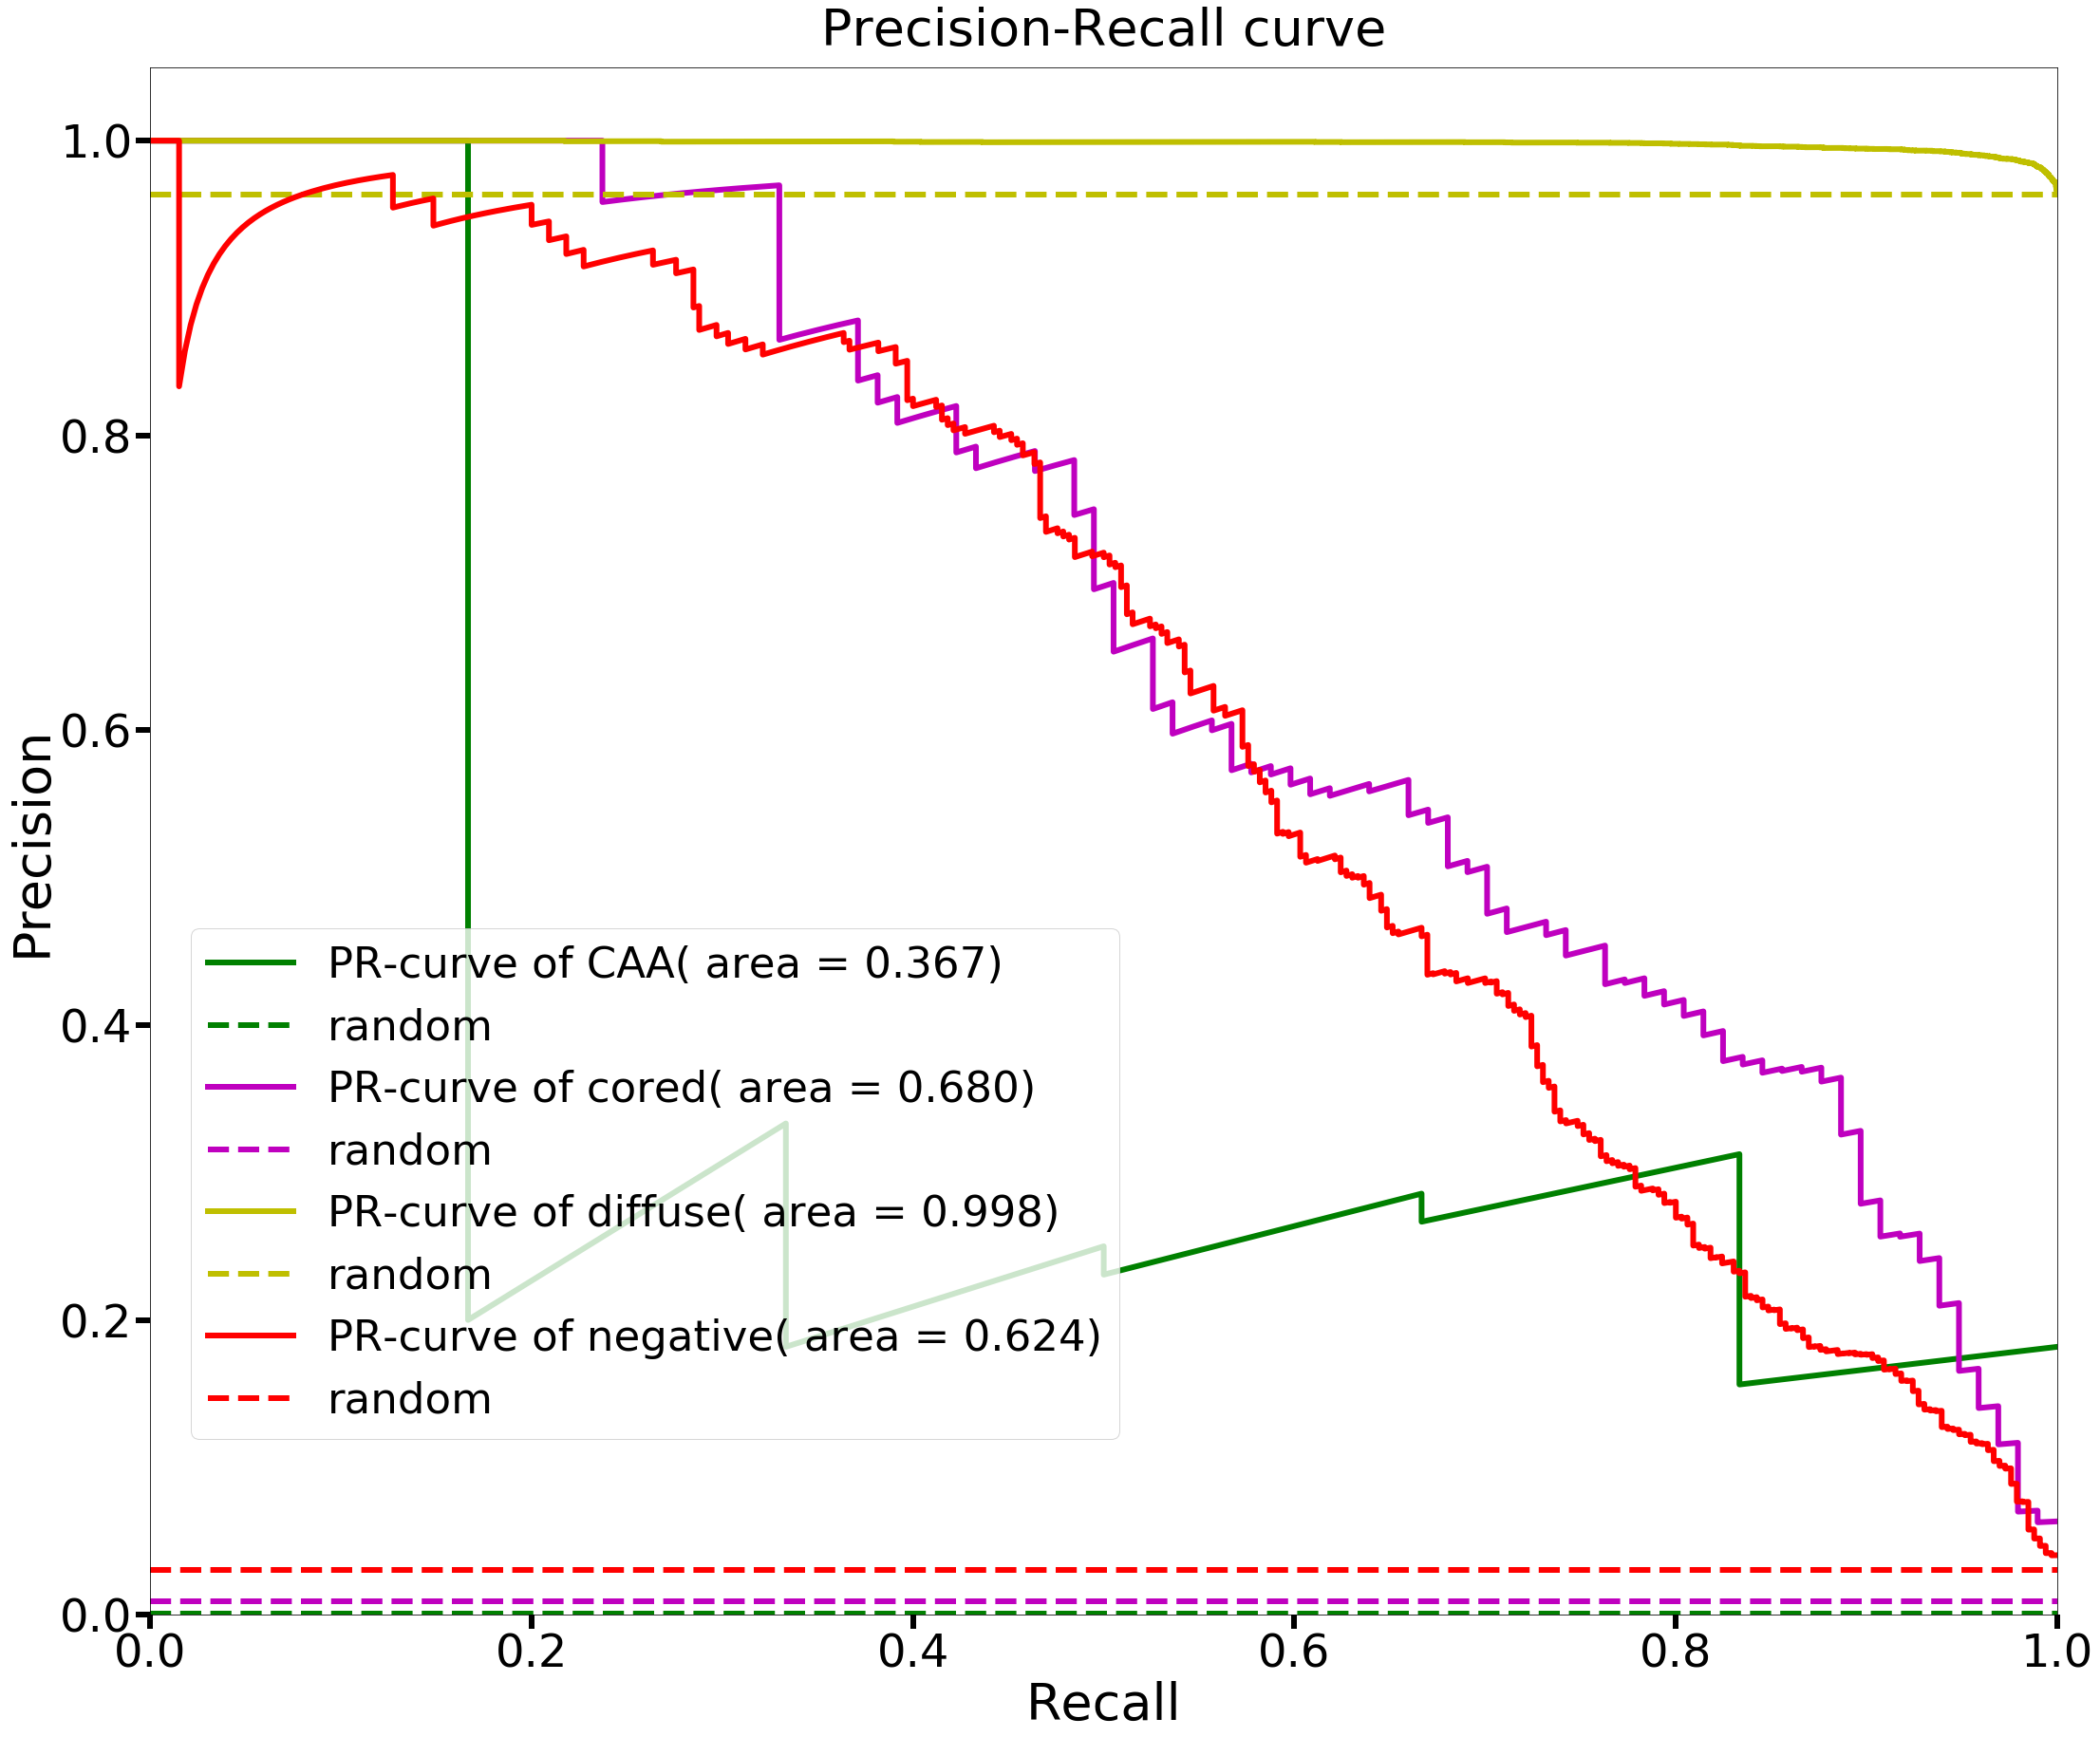

In [25]:
plot_roc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(models_dir, f'{model_name}_roc_plot.png'))
plot_prc(preds.numpy(), y.numpy(), learn.data.classes, size=30,
         path=os.path.join(models_dir, f'{model_name}_prc_plot.png'))

In [16]:
l = losses.numpy()
losses_df = pd.DataFrame(np.reshape(l, (int(l.shape[0]/4), 4)), columns=learn.data.classes)
losses_df

,CAA,cored,diffuse,negative
0,5.006777e-06,9.865455e-03,0.090560,0.000260
1,1.330287e-04,1.873525e-03,0.558732,0.659217
2,0.000000e+00,5.936447e-05,0.000035,0.000272
3,5.953923e-04,1.582919e-03,0.004255,0.011298
4,2.974136e-03,4.206619e-03,0.628532,0.722996
...,...,...,...,...
10811,3.779412e-04,1.616370e-01,0.886168,0.266784
10812,9.536739e-07,3.266281e-05,0.003008,0.004414
10813,0.000000e+00,8.106199e-06,0.002784,0.003197
10814,3.933899e-06,4.768370e-07,0.013955,0.018290


In [17]:
a = pd.DataFrame(losses_df.sum(axis=1), columns=['loss'])
top_losses = a.sort_values(['loss'], ascending=False)[0:10]
top

NameError: name 'top' is not defined

In [ ]:
open_image(os.path.join(img_path_test, 'hold-out', test.loc[test.index.isin(top_losses.index), 'imagename'].values[0]))